In [1]:
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import Activation, BatchNormalization, MaxPool2D
from keras.layers import UpSampling2D, Input
from keras.optimizers import adam_v2
from keras.utils.vis_utils import plot_model
import tensorflow
from keras import backend as K
from keras.losses import binary_crossentropy, categorical_crossentropy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from random import randint
import cv2
from glob import glob
from sklearn.preprocessing import LabelEncoder
from skimage.io import imread
from keras_preprocessing.image import load_img, img_to_array
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import pickle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.optimizer_v2.adam import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from keras.applications.mobilenet import preprocess_input

In [2]:
def conv_block(input, num_of_filters):
  #First Set
  conv_op=Conv2D(num_of_filters, 3, padding="same")(input)
  conv_op=BatchNormalization()(conv_op)
  conv_op = Activation('relu')(conv_op)

  #Second Set
  conv_op=Conv2D(num_of_filters, 3, padding="same")(conv_op)
  conv_op=BatchNormalization()(conv_op)
  conv_op = Activation('relu')(conv_op)

  return conv_op

def encoder_block(input, num_of_filters):
  encode = conv_block(input, num_of_filters)
  max_pool = MaxPool2D(pool_size=(2,2))(encode)

  return encode, max_pool

def decoder_block(input, skip_connection, num_of_filters):
  conv_trans = Conv2DTranspose(num_of_filters, (2,2), strides=2, padding="same")(input)
  conv_trans = Concatenate()([conv_trans, skip_connection])
  conv_trans = conv_block(conv_trans, num_of_filters)

  return conv_trans

#create model with specific input and no of classes
def create_model(input_shape, num_classes):

  inputs=Input(input_shape)

  c1,p1=encoder_block(inputs, 64)
  c2,p2=encoder_block(p1, 128)
  c3,p3=encoder_block(p2, 256)
  c4,p4=encoder_block(p3, 512)

  b1 = conv_block(p4, 1024)

  d1 = decoder_block(b1, c4, 512)
  d2 = decoder_block(d1, c3, 256)
  d3 = decoder_block(d2, c2, 128)
  d4 = decoder_block(d3, c1, 64)

  activation=""
  if num_classes==1:
    activation = "sigmoid"
  else:
    activation = "softmax"
  print(activation, num_classes, sep=" ")
  output = Conv2D(num_classes, 1, padding="same", activation=activation)(d4)

  model = Model(inputs=inputs, outputs=output, name="U-net-Model")
  return model


In [3]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tensorflow.keras.backend.epsilon())

def loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

def show_top_images_with_lables(images, lables, plot_random=True,cmap=None):
  columns = 4
  rows = 5
  fig=plt.figure(figsize=(12, 17))
  for i in range(1, columns*rows +1):
    index = None
    if plot_random == True:
      index = randint(0, (len(lables)-1))
    else:
      index = i
    fig.add_subplot(rows, columns, i).set_title(lables[index-1])
    plt.imshow(images[index-1], cmap=cmap)
  return plt.show()

def getCoordinates(annotations, image_jdata):
  coordinates=[]
  for annotation in annotations:
    if annotation['image_id'] == image_jdata["id"]:
      x,y,w,h = annotation['bbox']
      x = x/image_jdata['width']
      w = w/image_jdata['width']
      y = y/image_jdata['height']
      h = h/image_jdata['height']
      cc = (annotation["category_id"], [x,y,w,h], [image_jdata['width'], image_jdata['height']])
      coordinates.append(cc)
  return (image_jdata["id"], coordinates)

In [4]:
IMG_WIDTH=256
IMG_HEIGHT=256
NO_CHANNEL=3

In [12]:
json_path="/content/drive/MyDrive/ML-POC/trainval/annotations/bbox-annotations.json"
images_path="/content/drive/MyDrive/ML-POC/trainval/images/"

In [13]:
imgs_path=glob("{}*".format(images_path))
imgs_path.sort()

In [14]:
with open(json_path) as f:
  json_data = json.loads(f.read())

In [15]:
images = json_data['images']
categories = json_data['categories']
annotations = json_data['annotations']

In [9]:
len(images), len(annotations), len(categories)

(2239, 16772, 2)

In [16]:
image_data=[]
coordinates_data=[]
image_ids=[]
for i,img_path in enumerate(tqdm(imgs_path)):
  img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
  img = np.array(img)
  coo = getCoordinates(annotations, images[i])
  id, cc = coo
  coordinates_data.append(cc)
  image_data.append(img)
  image_ids.append(id)
image_data = np.array(image_data)
coordinates_data = np.array(coordinates_data)
image_ids=np.array(image_ids)

100%|██████████| 2239/2239 [01:31<00:00, 24.50it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


In [13]:
image_data = image_data/255.

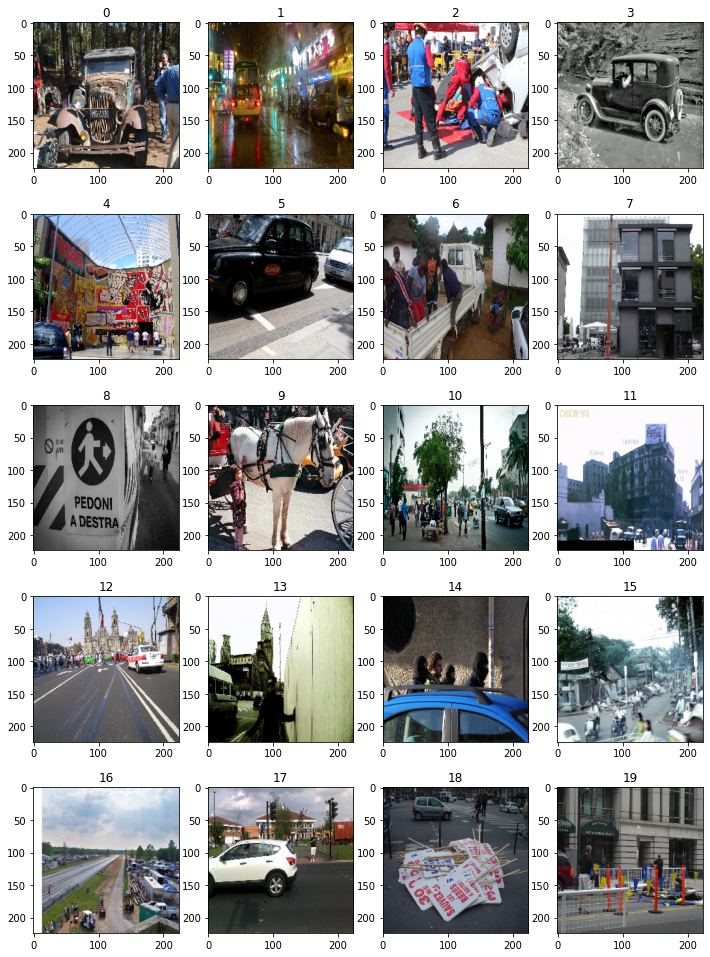

In [19]:
show_top_images_with_lables(image_data, image_ids, False)

In [ ]:
coordinates_data.shape

(2239,)

In [20]:
coordinates_data[0]

[(1, [0.826171875, 0.18880208333333334, 0.142578125, 0.62109375], [1024, 768]),
 (1, [0.828125, 0.28125, 0.1708984375, 0.7174479166666666], [1024, 768]),
 (2, [0.072265625, 0.20703125, 0.0732421875, 0.10546875], [1024, 768]),
 (2,
  [0.1494140625, 0.16145833333333334, 0.642578125, 0.8372395833333334],
  [1024, 768])]

In [21]:
masks = []

for i,coordinate in enumerate(tqdm(coordinates_data)):
  aw,ah = tuple(coordinate[0][2])
  amasks = np.zeros((IMG_WIDTH,IMG_HEIGHT))
  for c in coordinate:
    cat = c[0]
    x,y,w,h = tuple(c[1])
    #print(cat)
    x1=int(x*IMG_WIDTH)
    x2=int(w*IMG_WIDTH)+int(x*IMG_WIDTH)
    y1= int(y*IMG_HEIGHT)
    y2= int(y*IMG_HEIGHT)+int(h*IMG_HEIGHT)
    amasks[y1:y2, x1:x2] = cat
  masks.append(amasks)
masks=np.array(masks)

100%|██████████| 2239/2239 [00:00<00:00, 5160.12it/s]


In [22]:
np.unique(masks)

array([0., 1., 2.])

In [23]:
masks.shape

(2239, 224, 224)

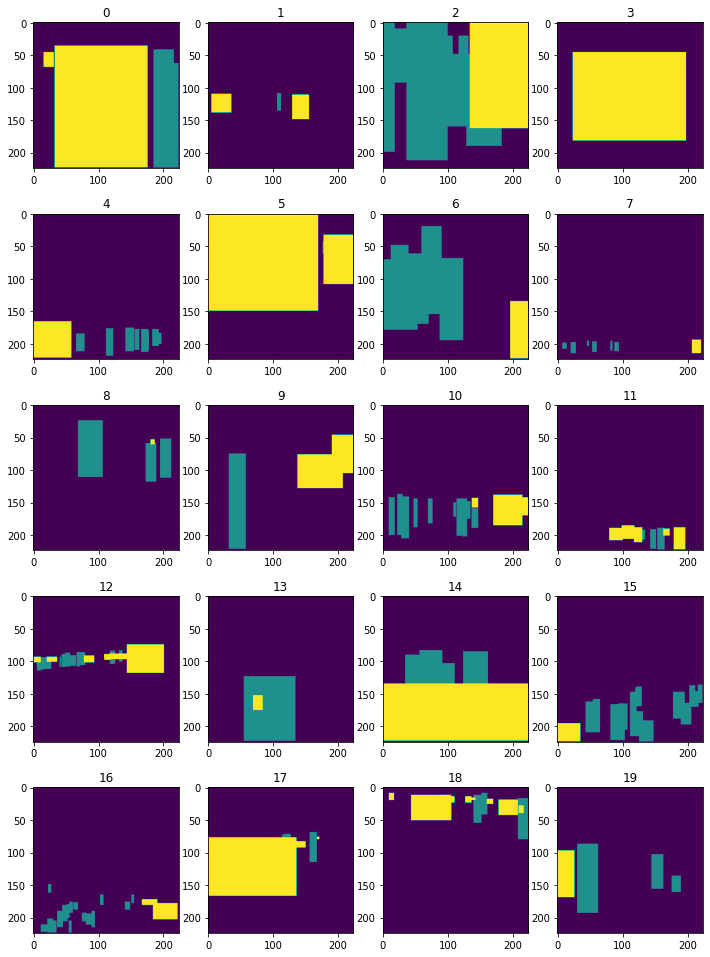

In [24]:
show_top_images_with_lables(masks, image_ids, False)

In [25]:
dataset = {
    "image_data": image_data,
    "image_ids": image_ids,
    "masks": masks
}

with open("/content/drive/MyDrive/ML-POC/dataset_correct224x224.pkl", 'ab') as f:
  pickle.dump(dataset,f)

In [5]:
with open("/content/drive/MyDrive/ML-POC/dataset_correct224x224.pkl", 'rb') as f:
  img_ds = pickle.load(f)


In [6]:
image_data = img_ds["image_data"]
masks= img_ds["masks"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(image_data, masks, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1567, 224, 224, 3), (672, 224, 224, 3), (1567, 224, 224), (672, 224, 224))

In [8]:
train_cat_msk = to_categorical(y_train, num_classes=3)
y_train_cat = train_cat_msk.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 3)

test_cat_msk = to_categorical(y_test, num_classes=3)
y_test_cat = test_cat_msk.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2], 3)

In [28]:
y_train_cat.shape,y_test_cat.shape

((1567, 224, 224, 3), (672, 224, 224, 3))

In [213]:
input_shape = (IMG_HEIGHT,IMG_WIDTH,NO_CHANNEL)
my_unet_model = create_model(input_shape, num_classes=3)
my_unet_model.summary()

softmax 3
Model: "U-net-Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                             

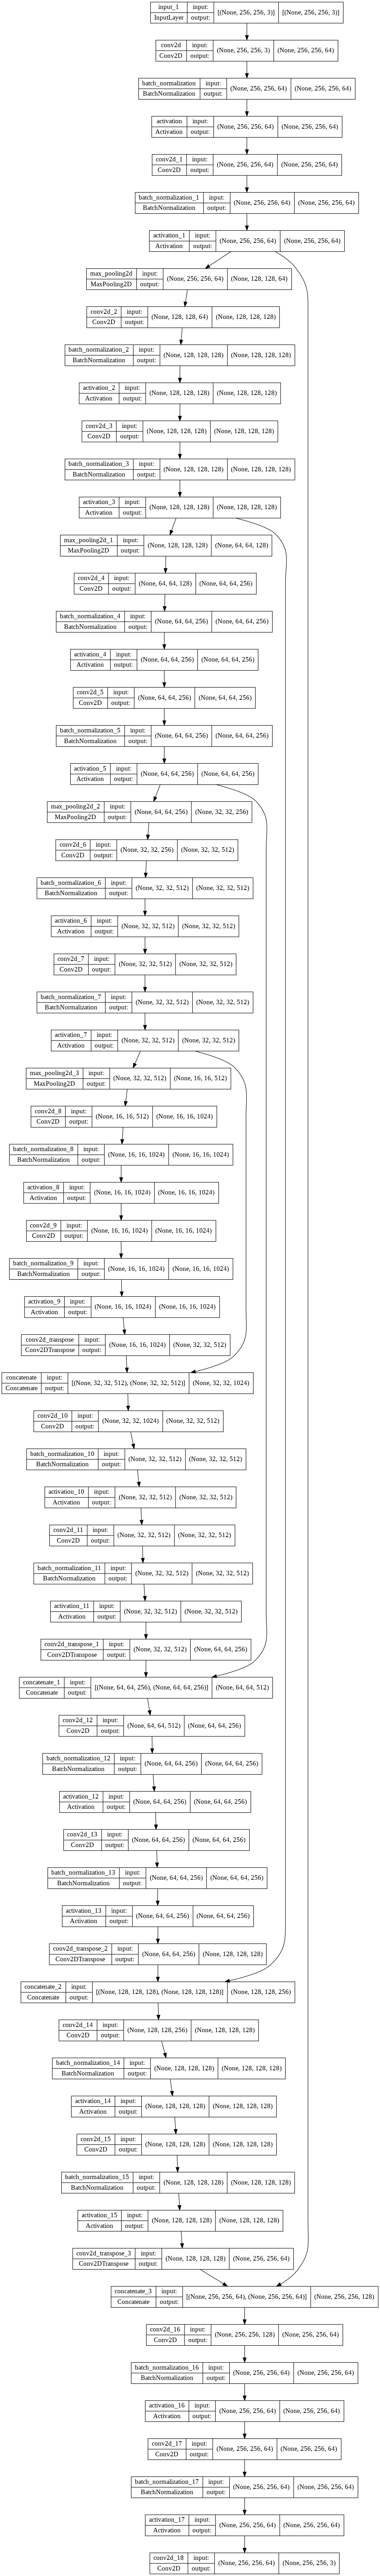

In [31]:
plot_model(my_unet_model, "my_unet_model.png", show_shapes=True, show_layer_names=True)

In [214]:
optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
my_unet_model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [215]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/ML-POC/correct_model_weights/model-weights-val_dice_coefficient-{val_dice_coefficient:.2f}-val_loss-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True) # To Save the weight of the best performing model
early_stop = EarlyStopping(monitor="val_loss", patience=10) #Stop Early if the model converges very quickly before it over fits.

In [36]:
no_epochs = 20

In [37]:
with tf.device('/device:GPU:0'):
  history = my_unet_model.fit(X_train, y_train_cat, validation_data = (X_test, y_test_cat), epochs=no_epochs, batch_size=10, verbose=1, callbacks=[checkpoint,early_stop])

Epoch 1/50
157/157 [==============================] - ETA: 0s - loss: 1.4209 - dice_coefficient: 0.5650
Epoch 1: val_loss improved from inf to 2.07654, saving model to /content/drive/MyDrive/ML-POC/correct_model_weights/model-weights-val_dice_coefficient-0.58-val_loss-2.08.h5
157/157 [==============================] - 68s 350ms/step - loss: 1.4209 - dice_coefficient: 0.5650 - val_loss: 2.0765 - val_dice_coefficient: 0.5847
Epoch 2/50
157/157 [==============================] - ETA: 0s - loss: 1.2064 - dice_coefficient: 0.6318
Epoch 2: val_loss did not improve from 2.07654
157/157 [==============================] - 50s 322ms/step - loss: 1.2064 - dice_coefficient: 0.6318 - val_loss: 2.2446 - val_dice_coefficient: 0.6037
Epoch 3/50
157/157 [==============================] - ETA: 0s - loss: 1.1337 - dice_coefficient: 0.6554
Epoch 3: val_loss improved from 2.07654 to 1.40509, saving model to /content/drive/MyDrive/ML-POC/correct_model_weights/model-weights-val_dice_coefficient-0.66-val_loss

In [38]:
model_history = history.history

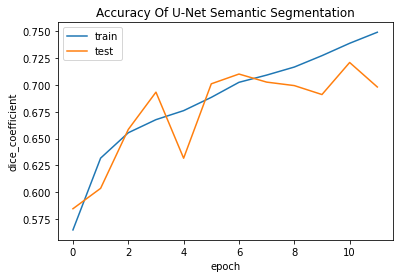

In [39]:
plt.plot(model_history['dice_coefficient'])
plt.plot(model_history['val_dice_coefficient'])
plt.title('Accuracy Of U-Net Semantic Segmentation')
plt.ylabel('dice_coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

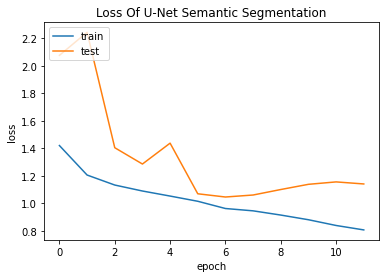

In [41]:
# summarize history for loss
plt.plot(model_history['loss'])
plt.plot(model_history['val_loss'])
plt.title('Loss Of U-Net Semantic Segmentation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
my_unet_model.save("/content/drive/MyDrive/ML-POC/my_unet_model.h5")

In [47]:
loss, dice_coefficient = my_unet_model.evaluate(X_test, y_test_cat)
print(f"loss: {loss:.2f} dice_coefficient: {dice_coefficient:.2f}")

21/21 [==============================] - 5s 257ms/step - loss: 1.1383 - dice_coefficient: 0.6974
loss: 1.14 dice_coefficient: 0.70


In [48]:
del image_data, masks

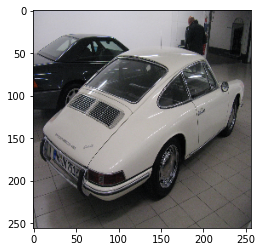

In [56]:
plt.imshow(X_train[1])

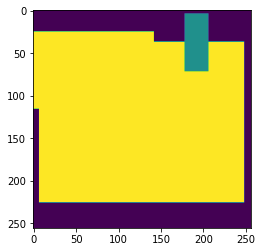

In [55]:
plt.imshow(np.argmax(y_train_cat[1], axis=2))

In [7]:
from skimage.measure import find_contours, label, regionprops

In [8]:
def predict_bbox(msk):
  mssk = np.argmax(msk, axis=2)
  label_img= label(mssk)
  
  regions = regionprops(label_img)
  bboxes = []
  for region in regions:
    x1 = region.bbox[1]
    y1 = region.bbox[0]

    x2 = region.bbox[3]
    y2 = region.bbox[2]
    bboxes.append([x1, y1, x2, y2])
  return bboxes


In [29]:
i=113

In [199]:
bboxs= predict_bbox(y_test_cat[i])
print(bboxs)
#plt.imshow()

[[205, 18, 232, 37], [19, 32, 37, 110], [27, 37, 255, 228]]


In [181]:
my_unet_model.load_weights("/content/drive/MyDrive/ML-POC/correct_model_weights/model-weights-val_dice_coefficient-0.71-val_loss-1.05.h5")

In [205]:
mask_pred = my_unet_model.predict(np.expand_dims(X_test[i], axis=0))

In [206]:
im= X_test[i]

In [207]:
bboxs = predict_bbox(mask_pred[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


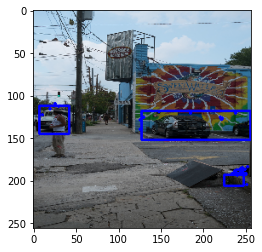

In [208]:
for bbox in bboxs:
  #if(area())
  im = cv2.rectangle(im, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0,0,255), 2)

plt.imshow(im)

###**MobileNet Transfer learning**

In [5]:
from keras.applications.mobilenet import MobileNet
from keras.layers import Reshape, Concatenate

In [6]:
IMG_WIDTH=224
IMG_HEIGHT=224
NO_CHANNEL=3
alpha = 1

In [11]:
def create_model(trainable=True, n_classes=1):
    model = MobileNet(input_shape=(IMG_HEIGHT, IMG_WIDTH, NO_CHANNEL), include_top=False, alpha=alpha, weights="imagenet") # Load pre-trained mobilenet
    for layer in model.layers:
        layer.trainable = trainable

     
    block0 = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block0])
    x = UpSampling2D()(x)
    if n_classes == 1:
      x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    else:
      x = Conv2D(n_classes, kernel_size=1, activation="softmax")(x)

    #x = Reshape((IMG_HEIGHT, IMG_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

In [12]:
model=create_model(trainable=False,n_classes=3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                             

In [29]:
optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [30]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/ML-POC/ModelCheckPoint/mob-net-model-weights-val_dice_coefficient-{val_dice_coefficient:.2f}-val_loss-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True) # To Save the weight of the best performing model
early_stop = EarlyStopping(monitor="val_loss", patience=5) #Stop Early if the model converges very quickly before it over fits.

In [19]:
#@title No of epochs
#@markdown Change the no of epoch for more training.
no_of_epochs =  100#@param {type:"number"} 

In [32]:
with tf.device('/device:GPU:0'):
  mob_net_history=model.fit(X_train, y_train_cat, validation_data = (X_test, y_test_cat), epochs=no_of_epochs, batch_size=10, verbose=1, callbacks=[checkpoint,early_stop])

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 1.7515 - dice_coefficient: 0.5356
Epoch 1: val_loss improved from inf to 1.48956, saving model to /content/drive/MyDrive/ML-POC/ModelCheckPoint/mob-net-model-weights-val_dice_coefficient-0.60-val_loss-1.49.h5
157/157 [==============================] - 41s 190ms/step - loss: 1.7515 - dice_coefficient: 0.5356 - val_loss: 1.4896 - val_dice_coefficient: 0.5978
Epoch 2/100
157/157 [==============================] - ETA: 0s - loss: 1.4334 - dice_coefficient: 0.6030
Epoch 2: val_loss improved from 1.48956 to 1.34875, saving model to /content/drive/MyDrive/ML-POC/ModelCheckPoint/mob-net-model-weights-val_dice_coefficient-0.63-val_loss-1.35.h5
157/157 [==============================] - 28s 182ms/step - loss: 1.4334 - dice_coefficient: 0.6030 - val_loss: 1.3488 - val_dice_coefficient: 0.6304
Epoch 3/100
157/157 [==============================] - ETA: 0s - loss: 1.3206 - dice_coefficient: 0.6279
Epoch 3: val_loss improved from

In [33]:
history=mob_net_history.history

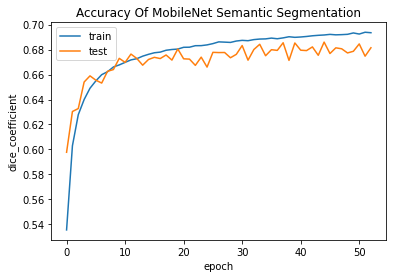

In [34]:
# summarize history for accuracy
plt.plot(history['dice_coefficient'])
plt.plot(history['val_dice_coefficient'])
plt.title('Accuracy Of MobileNet Semantic Segmentation')
plt.ylabel('dice_coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

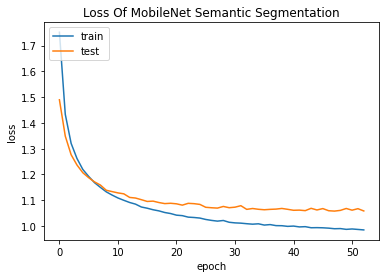

In [35]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss Of MobileNet Semantic Segmentation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
preprocessed_X_train=preprocess_input(X_train)
preprocessed_X_test =preprocess_input(X_test)

In [15]:
preprocessed_X_train.shape, preprocessed_X_test.shape

((1567, 224, 224, 3), (672, 224, 224, 3))

In [16]:
optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [17]:
checkpoint_pi = ModelCheckpoint("/content/drive/MyDrive/ML-POC/ModelCheckPoint/mob-net-model-weights-val-dice-coefficient-pi-{val_dice_coefficient:.2f}-val-loss-pi-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True) # To Save the weight of the best performing model
early_stop_pi = EarlyStopping(monitor="val_loss", patience=5) #Stop Early if the model converges very quickly before it over fits.

In [20]:
with tf.device('/device:GPU:0'):
  mob_net_history=model.fit(preprocessed_X_train, y_train_cat, validation_data = (preprocessed_X_test, y_test_cat), epochs=no_of_epochs, batch_size=10, verbose=1, callbacks=[checkpoint_pi,early_stop_pi])

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 1.9241 - dice_coefficient: 0.5459
Epoch 1: val_loss improved from inf to 1.49142, saving model to /content/drive/MyDrive/ML-POC/ModelCheckPoint/mob-net-model-weights-val-dice-coefficient-pi-0.63-val-loss-pi-1.49.h5
157/157 [==============================] - 34s 194ms/step - loss: 1.9241 - dice_coefficient: 0.5459 - val_loss: 1.4914 - val_dice_coefficient: 0.6305
Epoch 2/100
157/157 [==============================] - ETA: 0s - loss: 1.3065 - dice_coefficient: 0.6605
Epoch 2: val_loss improved from 1.49142 to 1.21592, saving model to /content/drive/MyDrive/ML-POC/ModelCheckPoint/mob-net-model-weights-val-dice-coefficient-pi-0.68-val-loss-pi-1.22.h5
157/157 [==============================] - 29s 184ms/step - loss: 1.3065 - dice_coefficient: 0.6605 - val_loss: 1.2159 - val_dice_coefficient: 0.6841
Epoch 3/100
157/157 [==============================] - ETA: 0s - loss: 1.1358 - dice_coefficient: 0.6990
Epoch 3: val_loss i

In [21]:
history=mob_net_history.history

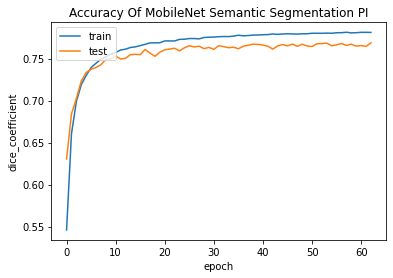

In [22]:
# summarize history for accuracy
plt.plot(history['dice_coefficient'])
plt.plot(history['val_dice_coefficient'])
plt.title('Accuracy Of MobileNet Semantic Segmentation PI')
plt.ylabel('dice_coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

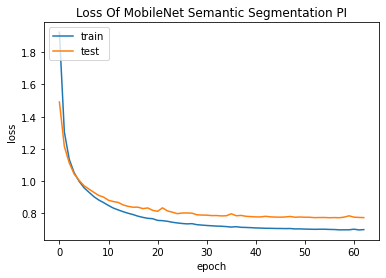

In [23]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss Of MobileNet Semantic Segmentation PI')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
model.save("/content/drive/MyDrive/ML-POC/mobile_net_pi_model.h5")

In [9]:
model = tf.keras.models.load_model("/content/drive/MyDrive/ML-POC/mobile_net_pi_model.h5", compile=False)
model.load_weights("/content/drive/MyDrive/ML-POC/ModelCheckPoint/mob-net-model-weights-val-dice-coefficient-pi-0.77-val-loss-pi-0.77.h5")

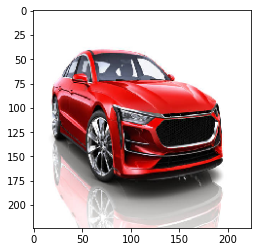

In [18]:
image = load_img("/content/car.jpeg", target_size=(IMG_HEIGHT, IMG_WIDTH))
image = np.array(image)
plt.imshow(image)
a_img = image.copy()

In [19]:
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)
image.shape

(1, 224, 224, 3)

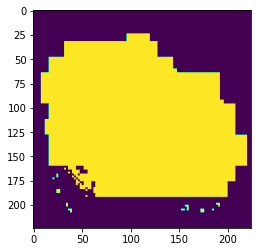

In [22]:
pred = model.predict(image)
pred = np.argmax(pred[0], axis=2)
plt.imshow(pred)

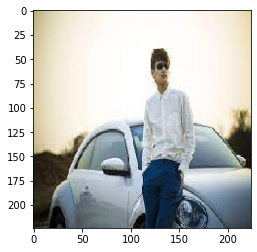

In [27]:
image = load_img("/content/pac.jpeg", target_size=(IMG_HEIGHT, IMG_WIDTH))
image = np.array(image)
plt.imshow(image)
a_img = image.copy()

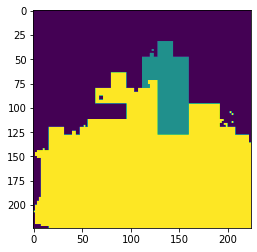

In [28]:
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)
image.shape
pred = model.predict(image)
pred = np.argmax(pred[0], axis=2)
plt.imshow(pred)

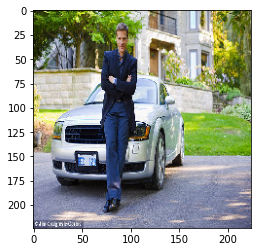

In [30]:
image = load_img("/content/pac1.jpeg", target_size=(IMG_HEIGHT, IMG_WIDTH))
image = np.array(image)
plt.imshow(image)
a_img = image.copy()

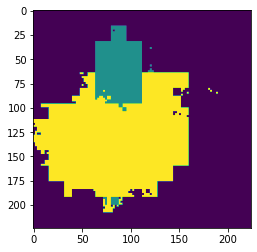

In [31]:
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)
image.shape
pred = model.predict(image)
pred = np.argmax(pred[0], axis=2)
plt.imshow(pred)

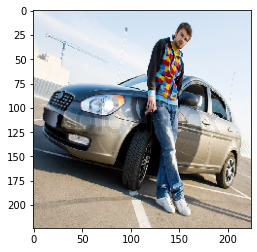

In [32]:
image = load_img("/content/pac2.jpeg", target_size=(IMG_HEIGHT, IMG_WIDTH))
image = np.array(image)
plt.imshow(image)
a_img = image.copy()

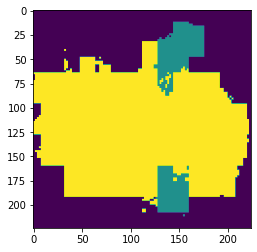

In [33]:
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)
image.shape
pred = model.predict(image)
pred = np.argmax(pred[0], axis=2)
plt.imshow(pred)

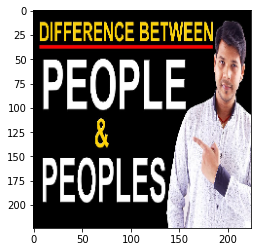

In [35]:
image = load_img("/content/pac3.jpeg", target_size=(IMG_HEIGHT, IMG_WIDTH))
image = np.array(image)
plt.imshow(image)
a_img = image.copy()

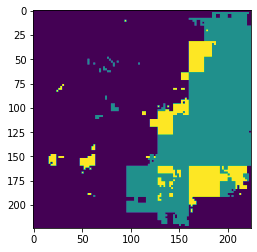

In [36]:
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)
image.shape
pred = model.predict(image)
pred = np.argmax(pred[0], axis=2)
plt.imshow(pred)

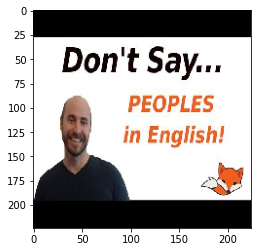

In [37]:
image = load_img("/content/pac4.jpeg", target_size=(IMG_HEIGHT, IMG_WIDTH))
image = np.array(image)
plt.imshow(image)
a_img = image.copy()

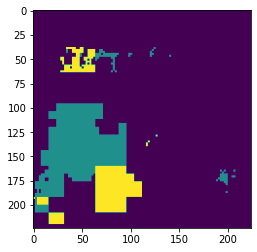

In [38]:
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)
image.shape
pred = model.predict(image)
pred = np.argmax(pred[0], axis=2)
plt.imshow(pred)